In [8]:
from scipy.spatial.transform import Rotation 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
import scipy

In [9]:
# 6.1
def gaussian1DKernel(sigma:int) -> np.ndarray:
    """create a 1D gaussian kernel
    g: kernel
    gd: derivative of kernel"""
    if sigma == 0:
        raise ValueError("sigma must be non-zero")
    width = 5*sigma
    interval = np.arange(-width, width+1)
    g = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-interval**2/(2*sigma**2))
    gd = -interval/(np.sqrt(2*np.pi)*sigma**3) * np.exp(-interval**2/(2*sigma**2))
    g = g.reshape(-1,1)
    gd = gd.reshape(-1,1)
    return g, gd

In [10]:
im = cv2.imread('data/week06_data/TestIm1.png', cv2.IMREAD_GRAYSCALE)
im = im.astype(float)/255

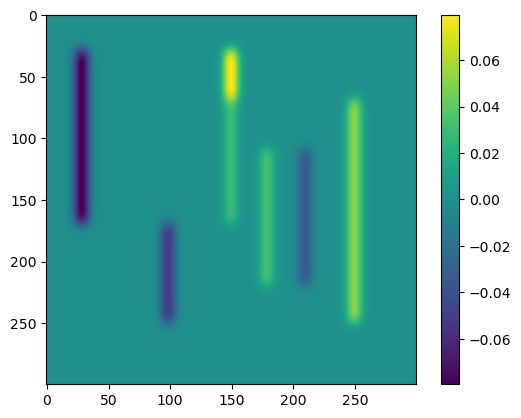

In [11]:
#6.2
def gaussianSmoothing(im:np.ndarray, sigma:int) -> np.ndarray:
    """smooth an image with a gaussian kernel
    I: smoothed image
    Ix: smoothed derivative in x direction
    Iy: smoothed derivative in y direction"""
    if sigma == 0:
        raise ValueError('sigma must be greater than 0')
    
    g, gd = gaussian1DKernel(sigma)
    I = cv2.filter2D(im, -1, kernel=g)
    I = cv2.filter2D(I, -1, kernel=g.T)
    
    Ix = cv2.filter2D(im, -1, kernel=g)
    Ix = cv2.filter2D(Ix, -1, kernel=gd.T)

    Iy = cv2.filter2D(im, -1, kernel=g.T)
    Iy = cv2.filter2D(Iy, -1, kernel=gd)
    return I, Ix, Iy
    
I, Ix, Iy = gaussianSmoothing(im, 5)
plt.imshow(Ix)
plt.colorbar();

In [12]:
# 6.3
def smoothedHessian(im, sigma, epsilon):
    """compute the smoothed Hessian matrix
    C: Hessian matrix"""
    I, Ix, Iy = gaussianSmoothing(im, sigma)
    g_epsilon, gd_epsilon = gaussian1DKernel(epsilon)
    Ixx = Ix**2
    Ixy = Ix * Iy
    Iyy = Iy ** 2
    ll = cv2.filter2D(Ixx, -1, kernel=g_epsilon)
    ll = cv2.filter2D(ll, -1, kernel=g_epsilon.T)
    ls = cv2.filter2D(Ixy, -1, kernel=g_epsilon)
    ls = cv2.filter2D(ls, -1, kernel=g_epsilon.T)
    lr = cv2.filter2D(Iyy, -1, kernel=g_epsilon)
    lr = cv2.filter2D(lr, -1, kernel=g_epsilon.T)
    C = np.array([[ll, ls], [ls, lr]])
    return C
C = smoothedHessian(im, 5, 0.01)

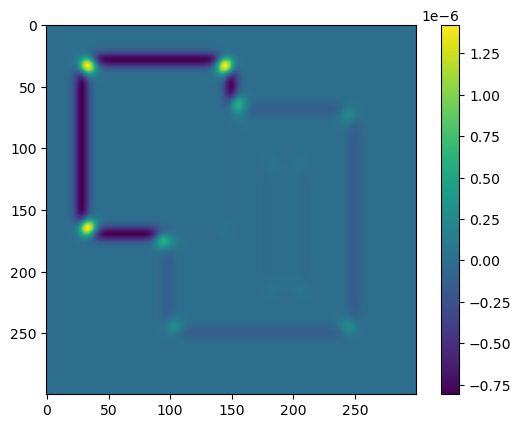

In [13]:
# 6.4
def harrisMeasure(im, sigma, epsilon, k=0.06):
    """compute the harris measure
    R: harris measure"""
    if epsilon == 0:
        raise ValueError('epsilon must be greater than 0')

    C = smoothedHessian(im, sigma, epsilon)
    a = C[0,0,:,:]
    b = C[1,1,:,:]
    c = C[0,1,:,:]
    r = a * b - c**2 - k*(a + b)**2
    return r
# does epsilon need to be equal to sigma?
r = harrisMeasure(im, 5, 5)
plt.imshow(r)
plt.colorbar();

In [25]:
# 6.5
def cornerDetector(im, sigma, epsilon, k=0.06, tau=0.01) -> list:
    """detect corners
    using non-maximum suppression
    return corners: list of corners"""
    r = harrisMeasure(im, sigma, epsilon, k)
    I = r > tau
    corners = []
    for i in range(1, r.shape[0]-1):
        for j in range(1, r.shape[1]-1):
            if I[i,j] :
                if r[i,j] > r[i+1,j] and r[i,j] > r[i-1,j] and r[i,j] > r[i,j+1] and r[i,j] > r[i,j-1]:
                    corners.append((j,i))

    return corners
c = cornerDetector(im, 5, 6, 0.06, 1e-8)
c = np.array(c)
c

array([[ 34,  34],
       [144,  34],
       [156,  65],
       [244,  74],
       [184, 114],
       [204, 114],
       [ 34, 164],
       [144, 164],
       [ 95, 176],
       [184, 214],
       [204, 214],
       [104, 244],
       [244, 244]])

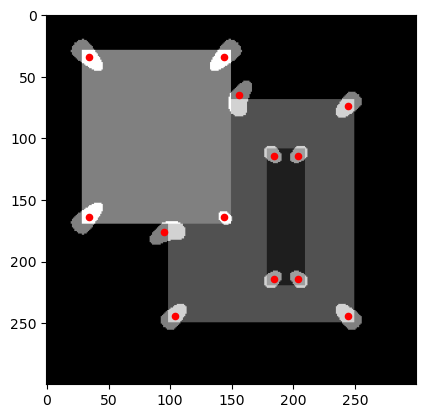

In [26]:
mask = r > 1e-8
img2 = 0.5*im + 0.5*mask
plt.scatter(c[:,0], c[:,1], s=20,c='r', marker='o')
plt.imshow(img2, cmap='gray');

The smallest value between threshold1 and threshold2 is used for edge linking. The largest value is used to find initial segments of strong edges. See http://en.wikipedia.org/wiki/Canny_edge_detector

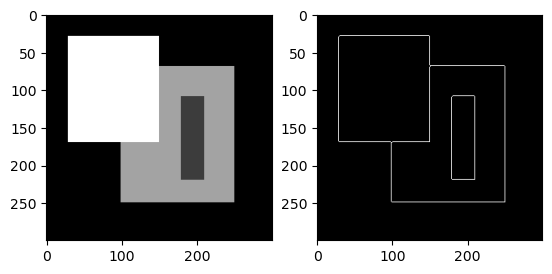

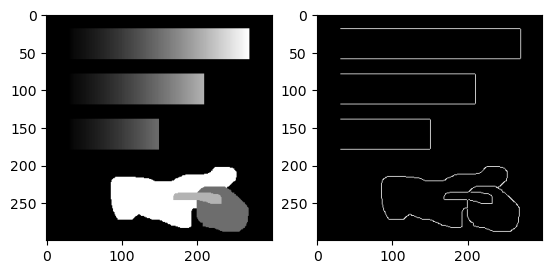

In [55]:
# 6.6
im = cv2.imread('data/week06_data/TestIm1.png', cv2.IMREAD_GRAYSCALE)
# im = im.astype(float)/255
im2 = cv2.imread('data/week06_data/TestIm2.png', cv2.IMREAD_GRAYSCALE)
# im2 = im2.astype(float)/255
# cv2.Canny(image, threshold1, threshold2)
# first threshold for the hysteresis procedure.
# second threshold for the hysteresis procedure.
edges = cv2.Canny(im, 0.1, 0.2)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im, cmap='gray');
ax[1].imshow(edges, cmap='gray');

# 6.7 effect of the thresholds
edges = cv2.Canny(im2, 17, 16)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im2, cmap='gray');
ax[1].imshow(edges, cmap='gray');